In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [38]:
train_data =pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test_data =pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
submission_data =pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [39]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [40]:
train_data.shape

(1460, 81)

In [41]:

test_data.shape

(1459, 80)

## Data Cleaning


In [42]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [43]:
# no missing value in train_data dataset

In [44]:
test_data.shape

(1459, 80)

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression

# Fill nan rows with 0
# train_data  = train_data.fillna(0)
train_data= train_data.replace({np.nan: 'missing'})

X = train_data.copy()
y = X.pop("SalePrice")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int



def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression( X, y,random_state=1)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores

OverallQual      0.511185
BsmtQual         0.342808
GarageArea       0.290198
YearBuilt        0.254612
YearRemodAdd     0.213258
Fireplaces       0.174902
MSZoning         0.128825
MasVnrType       0.107355
LotArea          0.095234
SaleCondition    0.078850
SaleType         0.075450
Exterior2nd      0.071169
GarageYrBlt      0.059852
MSSubClass       0.056139
Fence            0.048733
WoodDeckSF       0.045151
BsmtExposure     0.038280
LotFrontage      0.026992
EnclosedPorch    0.022467
Alley            0.016692
ScreenPorch      0.014965
RoofStyle        0.011153
PoolArea         0.004776
Street           0.003004
Exterior1st      0.000000
BsmtFinSF2       0.000000
LandSlope        0.000000
Name: MI Scores, dtype: float64

In [47]:
# first select the first 10 features :improve on this number later
# create a  new dataframe with features with MI Score above 0.05

X = X[['OverallQual','BsmtQual','GarageArea','YearBuilt','YearRemodAdd','Fireplaces','MSZoning','MasVnrType','LotArea',
       'SaleCondition','SaleType','Exterior2nd','GarageYrBlt','MSSubClass'
                    ]]
# X.reset_index(drop=True)
X.head()

,OverallQual,BsmtQual,GarageArea,YearBuilt,YearRemodAdd,YearRemodAdd,Fireplaces,MSZoning,MasVnrType,LotArea,SaleCondition,SaleType,Exterior2nd,GarageYrBlt,MSSubClass
0,7,0,548,2003,2003,2003,0,0,0,8450,0,0,0,0,60
1,6,0,460,1976,1976,1976,1,0,1,9600,0,0,1,1,20
2,7,0,608,2001,2002,2002,1,0,0,11250,0,0,0,2,60
3,7,1,642,1915,1970,1970,1,0,1,9550,1,0,2,3,70
4,8,0,836,2000,2000,2000,1,0,0,14260,0,0,0,4,60


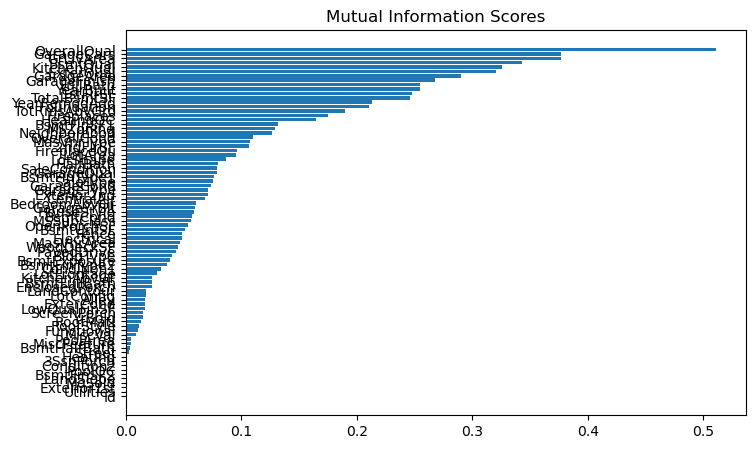

In [51]:
import matplotlib.pyplot as plt

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

OverallQual    0.511185
GarageCars     0.376849
GrLivArea      0.376789
BsmtQual       0.342808
KitchenQual    0.325435
                 ...   
BsmtFinSF2     0.000000
PoolQC         0.000000
Condition2     0.000000
LandSlope      0.000000
Id             0.000000
Name: MI Scores, Length: 80, dtype: float64

In [53]:
# Extracting some features from the dataset
features = ['OverallQual','BsmtQual','GarageArea','YearBuilt','YearRemodAdd','Fireplaces','MSZoning','MasVnrType','LotArea',
       'SaleCondition','SaleType','Exterior2nd','GarageYrBlt','MSSubClass'
                    ]
train_data = train_data[features]
train_data.head()

,OverallQual,BsmtQual,GarageArea,YearBuilt,YearRemodAdd,Fireplaces,MSZoning,MasVnrType,LotArea,SaleCondition,SaleType,Exterior2nd,GarageYrBlt,MSSubClass
0,7,Gd,548,2003,2003,0,RL,BrkFace,8450,Normal,WD,VinylSd,2003.0,60
1,6,Gd,460,1976,1976,1,RL,None,9600,Normal,WD,MetalSd,1976.0,20
2,7,Gd,608,2001,2002,1,RL,BrkFace,11250,Normal,WD,VinylSd,2001.0,60
3,7,TA,642,1915,1970,1,RL,None,9550,Abnorml,WD,Wd Shng,1998.0,70
4,8,Gd,836,2000,2000,1,RL,BrkFace,14260,Normal,WD,VinylSd,2000.0,60
